# Gradient boosting - Sentiment VS Economic indicators - MONTHLY

# Prepare workstation

In [419]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import shap
from datetime import datetime
import datetime as dt
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [420]:
# Set up the plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'serif'

# Load the data

In [422]:
# read the speeches with economic indicators file
df_speeches = pd.read_csv('sentiments_topics_monthly_indicators.csv')

In [423]:
# view number of rows and columns
df_speeches.shape

(670, 50)

In [424]:
# view number of columns
df_speeches.columns

Index(['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'central_bank',
       'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'month', 'cpi_rate',
       'ftse_vix', 'ftse_vix_pct_chg', 'gbp_usd_m', 'gfk_cc', 'hpi_mom',
       'hpi_yoy', 'avg_house_price', 'infl_exp', 'mortgage_approvals',
       'mortgage_2yr', 'mortgage_svr', 'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y',
       'rsi_vol', 'unemp_rate', 'wage_rate', 'pmi', 'topic_0', 'topic_1',
       'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
       'dominant_topic', 'dominant_topic_name'],
      dtype='object')

In [425]:
# convert 'date' column from df_speeches from 'object' datatype to 'date' datatype
df_speeches['date'] = pd.to_datetime(df_speeches['date'])

In [426]:
# confirm changes
df_speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     664 non-null    datetime64[ns]
 1   custom_ref               664 non-null    object        
 2   reference                516 non-null    object        
 3   title                    664 non-null    object        
 4   author                   664 non-null    object        
 5   is_gov                   664 non-null    float64       
 6   text                     664 non-null    object        
 7   finbert_pos              664 non-null    float64       
 8   finbert_neg              664 non-null    float64       
 9   finbert_neu              664 non-null    float64       
 10  finbert_sentiment        664 non-null    object        
 11  finbert_score            664 non-null    float64       
 12  finbert_confidence       664 non-nul

# Data wrangling

In [428]:
# define start and end dates for the range of dates required (20/01/15 to 16/12/2024) as confirmed by project focus area
start_date = '2015-01-20' 
end_date = '2024-12-16'

In [429]:
# Filter the DataFrame based on the date range.
df_speeches_subset = df_speeches[
    (df_speeches['date'] >= start_date) & (df_speeches['date'] <= end_date)
].copy()

In [430]:
# Print the shape of the subset
df_speeches_subset.shape

(664, 50)

In [431]:
# confirm min and max dates
print(df_speeches_subset['date'].min())
print(df_speeches_subset['date'].max())

2015-01-20 00:00:00
2024-12-16 00:00:00


In [432]:
# Filter the dataset to keep only rows where 'month' is not null
df_speeches_subset_filtered = df_speeches_subset[df_speeches_subset['month'].notna()]

In [433]:
# confirm rows and columns
df_speeches_subset_filtered.shape

(664, 50)

In [434]:
# confirm metadata
df_speeches_subset_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 0 to 663
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     664 non-null    datetime64[ns]
 1   custom_ref               664 non-null    object        
 2   reference                516 non-null    object        
 3   title                    664 non-null    object        
 4   author                   664 non-null    object        
 5   is_gov                   664 non-null    float64       
 6   text                     664 non-null    object        
 7   finbert_pos              664 non-null    float64       
 8   finbert_neg              664 non-null    float64       
 9   finbert_neu              664 non-null    float64       
 10  finbert_sentiment        664 non-null    object        
 11  finbert_score            664 non-null    float64       
 12  finbert_confidence       664 non-null    

In [435]:
# confirm columns
df_speeches_subset_filtered.columns

Index(['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'central_bank',
       'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'month', 'cpi_rate',
       'ftse_vix', 'ftse_vix_pct_chg', 'gbp_usd_m', 'gfk_cc', 'hpi_mom',
       'hpi_yoy', 'avg_house_price', 'infl_exp', 'mortgage_approvals',
       'mortgage_2yr', 'mortgage_svr', 'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y',
       'rsi_vol', 'unemp_rate', 'wage_rate', 'pmi', 'topic_0', 'topic_1',
       'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
       'dominant_topic', 'dominant_topic_name'],
      dtype='object')

In [436]:
# List of columns to include in df
selected_columns = [
    'date','month','custom_ref','finbert_score', 'central_bank','financial_sector', 'firms', 'government', 'households',
    'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'cpi_rate', 'gbp_usd_m', 'gfk_cc', 'unemp_rate', 'wage_rate']

In [437]:
# Create new df for only selected columns
df_speeches_subset_filtered_2 = df_speeches_subset_filtered[selected_columns].copy()

In [438]:
# create df_final which will be our single source of truth
df_final = df_speeches_subset_filtered_2.copy()

In [439]:
# confirm metadata of df_final
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 0 to 663
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     664 non-null    datetime64[ns]
 1   month                    664 non-null    object        
 2   custom_ref               664 non-null    object        
 3   finbert_score            664 non-null    float64       
 4   central_bank             664 non-null    float64       
 5   financial_sector         664 non-null    float64       
 6   firms                    664 non-null    float64       
 7   government               664 non-null    float64       
 8   households               664 non-null    float64       
 9   cbroberta_avg_score      664 non-null    float64       
 10  cbroberta_avg_sentiment  664 non-null    float64       
 11  cpi_rate                 664 non-null    float64       
 12  gbp_usd_m                664 non-null    

In [440]:
# view top 5 rows
df_final.head()

,date,month,custom_ref,finbert_score,central_bank,financial_sector,firms,government,households,cbroberta_avg_score,cbroberta_avg_sentiment,cpi_rate,gbp_usd_m,gfk_cc,unemp_rate,wage_rate
0,2015-01-20,2015-01,UK_2015-01-20_cunliffe,0.018576,-0.085677,-0.068065,0.229372,-0.185502,-0.244216,-0.061584,0.0,0.3,1.5143,1.0,5.6,1.5
1,2015-01-22,2015-01,UK_2015-01-22_fisher,0.139996,0.212500,-0.092043,0.042906,0.036313,-0.163172,-0.033054,0.0,0.3,1.5143,1.0,5.6,1.5
2,2015-01-22,2015-01,UK_2015-01-22_miles,-0.783304,-0.590841,-0.461428,-0.492868,-0.712214,-0.461885,-0.558391,0.0,0.3,1.5143,1.0,5.6,1.5
3,2015-01-23,2015-01,UK_2015-01-23_gracie,-0.155225,-0.023284,-0.324673,-0.232797,-0.068173,-0.148825,-0.275366,0.0,0.3,1.5143,1.0,5.6,1.5
4,2015-01-26,2015-01,UK_2015-01-26_forbes,-0.000569,-0.653483,-0.674422,-0.322947,-0.456708,-0.301404,-0.486471,0.0,0.3,1.5143,1.0,5.6,1.5


In [441]:
# Convert 'date' and 'month' to datetime objects
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['month'] = pd.to_datetime(df_final['month'])

# Sort by date to ensure correct lagging
df_final = df_final.sort_values(by='date').reset_index(drop=True)

print("Initial DataFrame Head:")
print(df_final.head())
print("\nInitial DataFrame Info:")
df_final.info()

Initial DataFrame Head:
        date      month              custom_ref  finbert_score  central_bank  \
0 2015-01-20 2015-01-01  UK_2015-01-20_cunliffe       0.018576     -0.085677   
1 2015-01-22 2015-01-01    UK_2015-01-22_fisher       0.139996      0.212500   
2 2015-01-22 2015-01-01     UK_2015-01-22_miles      -0.783304     -0.590841   
3 2015-01-23 2015-01-01    UK_2015-01-23_gracie      -0.155225     -0.023284   
4 2015-01-26 2015-01-01    UK_2015-01-26_forbes      -0.000569     -0.653483   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.068065  0.229372   -0.185502   -0.244216            -0.061584   
1         -0.092043  0.042906    0.036313   -0.163172            -0.033054   
2         -0.461428 -0.492868   -0.712214   -0.461885            -0.558391   
3         -0.324673 -0.232797   -0.068173   -0.148825            -0.275366   
4         -0.674422 -0.322947   -0.456708   -0.301404            -0.486471   

   cbroberta_avg_sentiment

In [442]:
# Align Daily Sentiment with Monthly Economic Indicators & Handle Monthly Data
# Aggregate daily sentiment scores to monthly averages
monthly_sentiment = df_final.groupby('month')[
    ['finbert_score', 'cbroberta_avg_score', 'central_bank', 'financial_sector', 'firms', 'government', 'households']
].mean().reset_index()

In [443]:
# Merge monthly sentiment with the monthly economic indicators.
monthly_econ_data_unique = df_final[['month', 'cpi_rate', 'gbp_usd_m', 'gfk_cc', 'unemp_rate', 'wage_rate']].drop_duplicates(subset=['month'])

# Combine monthly sentiment with monthly economic data
monthly_df = pd.merge(monthly_sentiment, monthly_econ_data_unique, on='month', how='inner')

# Sort by month for correct lagging
monthly_df = monthly_df.sort_values(by='month').set_index('month')

print("\nMonthly Aggregated DataFrame Head (for lagging):")
print(monthly_df.head())
print("\nMonthly Aggregated DataFrame Info:")
monthly_df.info()


Monthly Aggregated DataFrame Head (for lagging):
            finbert_score  cbroberta_avg_score  central_bank  \
month                                                          
2015-01-01      -0.091930            -0.300476     -0.235686   
2015-02-01       0.027714            -0.082324     -0.203433   
2015-03-01      -0.047618            -0.343616     -0.343756   
2015-05-01       0.115872            -0.396377     -0.317330   
2015-06-01       0.004905            -0.281783     -0.244776   

            financial_sector     firms  government  households  cpi_rate  \
month                                                                      
2015-01-01         -0.341905 -0.184262   -0.372016   -0.257172       0.3   
2015-02-01         -0.201117  0.287657    0.145076    0.036423       0.0   
2015-03-01         -0.452809 -0.159987   -0.347926   -0.346886       0.0   
2015-05-01         -0.461771 -0.126308   -0.505256   -0.398513       0.1   
2015-06-01         -0.355566 -0.147264   -0.3

In [444]:
# Feature Engineering: Create Lagged Features
# We'll create lags for both sentiment indicators and the economic indicators themselves.
sentiment_cols = ['finbert_score', 'cbroberta_avg_score', 'central_bank', 'financial_sector', 'firms', 'government', 'households']
economic_cols = ['cpi_rate', 'gbp_usd_m', 'gfk_cc', 'unemp_rate', 'wage_rate']

# Number of months to lag sentiment and economic indicators
# Let's consider 1, 2, and 3-month lags for sentiment
# For economic indicators, 1-month lag is usually sufficient as a strong predictor
lags_sentiment = [1, 2, 3] # Months
lags_econ = [1] # Months

# Create lagged sentiment features
for col in sentiment_cols:
    for lag in lags_sentiment:
        monthly_df[f'{col}_lag_{lag}m'] = monthly_df[col].shift(lag)

# Create lagged economic indicator features (these will be predictors for the *next* month's value)
for col in economic_cols:
    for lag in lags_econ: # Typically just 1-month lag for the target variable itself
        monthly_df[f'{col}_lag_{lag}m'] = monthly_df[col].shift(lag)

In [445]:
# Drop rows with NaN values resulting from lagging
df_model_ready = monthly_df.dropna()

print("\nDataFrame with Lagged Features Head:")
print(df_model_ready.head())
print("\nDataFrame with Lagged Features Info:")
df_model_ready.info()


DataFrame with Lagged Features Head:
            finbert_score  cbroberta_avg_score  central_bank  \
month                                                          
2015-05-01       0.115872            -0.396377     -0.317330   
2015-06-01       0.004905            -0.281783     -0.244776   
2015-07-01       0.003206            -0.353835     -0.239628   
2015-08-01      -0.002586            -0.496853     -0.496479   
2015-09-01      -0.021167            -0.320272     -0.280191   

            financial_sector     firms  government  households  cpi_rate  \
month                                                                      
2015-05-01         -0.461771 -0.126308   -0.505256   -0.398513       0.1   
2015-06-01         -0.355566 -0.147264   -0.313057   -0.263502       0.0   
2015-07-01         -0.344414 -0.276626   -0.484361   -0.246657       0.1   
2015-08-01         -0.443992 -0.586309   -0.367993   -0.256065       0.0   
2015-09-01         -0.382010 -0.092863   -0.325416   -0.3

In [446]:
# Data Scaling
# Define features (X) and target (y) for each economic indicator

# Get all potential feature columns (lagged sentiments and lagged economic indicators)
all_lagged_features = [col for col in df_model_ready.columns if '_lag_' in col]

# Initialize a StandardScaler
scaler = StandardScaler()

# Create a scaled DataFrame for features
X_scaled = df_model_ready[all_lagged_features].copy()
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns=X_scaled.columns, index=X_scaled.index)

print("\nScaled Features Head:")
print(X_scaled.head())


Scaled Features Head (Example):
            finbert_score_lag_1m  finbert_score_lag_2m  finbert_score_lag_3m  \
month                                                                          
2015-05-01             -0.149283              0.270165             -0.400226   
2015-06-01              0.775240             -0.156122              0.276635   
2015-07-01              0.147729              0.769027             -0.149539   
2015-08-01              0.138123              0.141091              0.775365   
2015-09-01              0.105368              0.131478              0.147595   

            cbroberta_avg_score_lag_1m  cbroberta_avg_score_lag_2m  \
month                                                                
2015-05-01                   -0.467122                    1.434641   
2015-06-01                   -0.857010                   -0.479046   
2015-07-01                   -0.010205                   -0.865468   
2015-08-01                   -0.542641                  

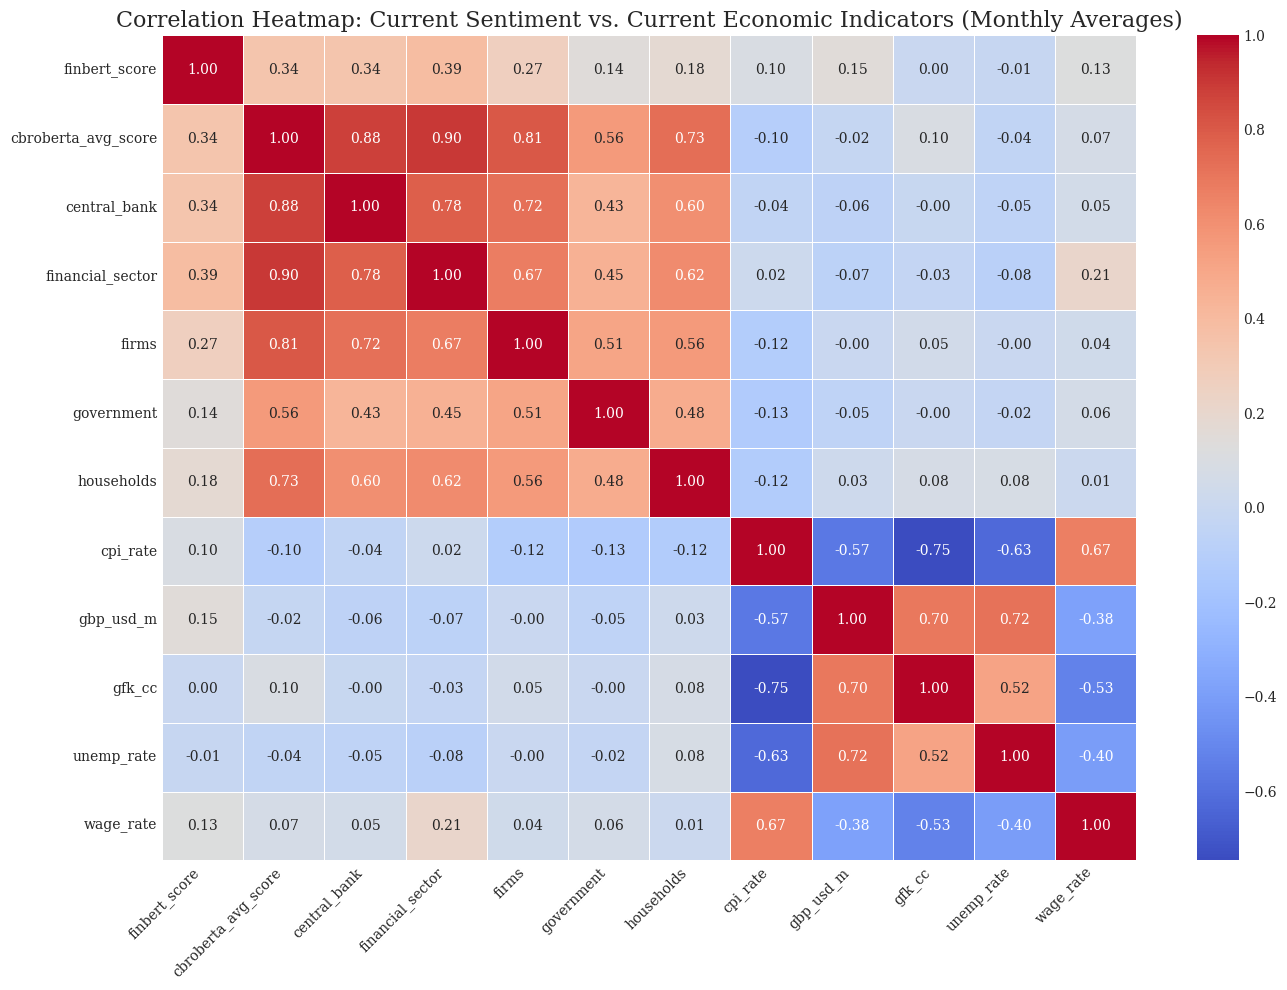

In [447]:
# Correlation Heatmap (Current Sentiment vs. Current Economic Indicators)
heatmap_cols = sentiment_cols + economic_cols
correlation_matrix = monthly_df[heatmap_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap: Current Sentiment vs. Current Economic Indicators (Monthly Averages)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_sentiment_econ.png') # Save the plot
plt.show()

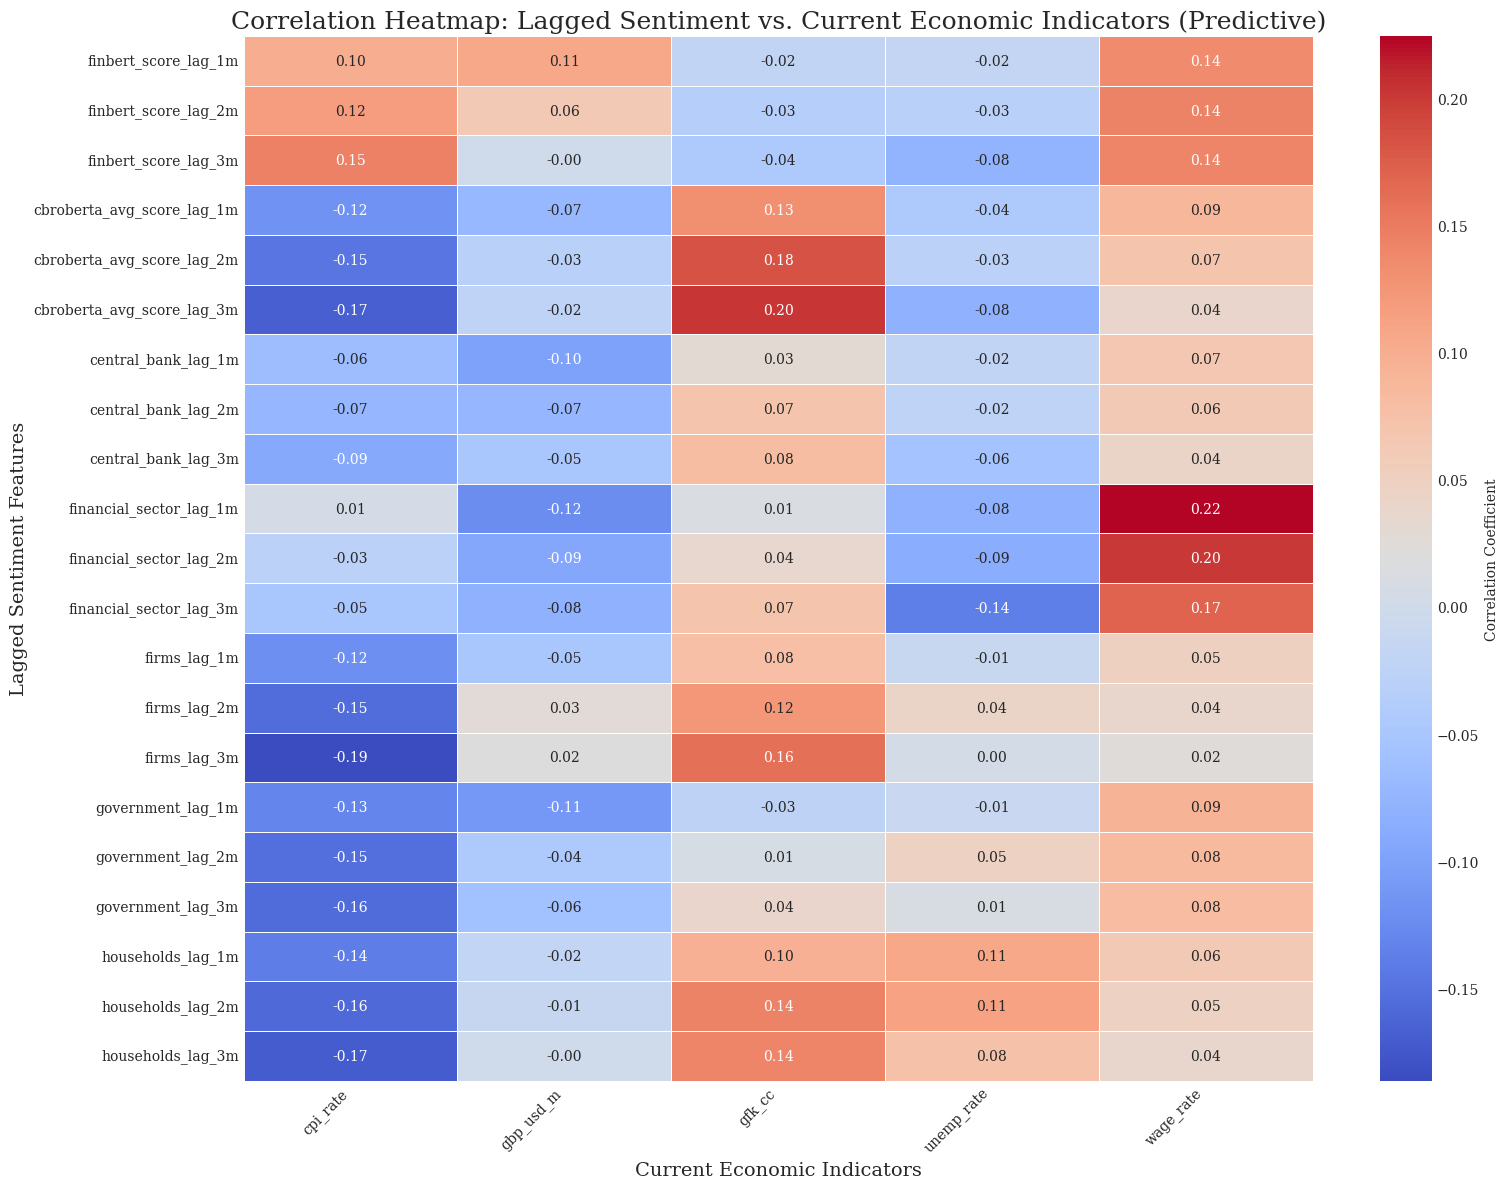

In [448]:
# Heatmap: Lagged Sentiment vs. Current Economic Indicators (Predictive)

lagged_sentiment_features = []
for col in sentiment_cols:
    for lag in lags_sentiment:
        lagged_sentiment_features.append(f'{col}_lag_{lag}m')

heatmap_cols_lagged = lagged_sentiment_features + economic_cols

correlation_matrix_lagged = df_model_ready[heatmap_cols_lagged].corr()
correlation_of_interest_predictive = correlation_matrix_lagged.loc[lagged_sentiment_features, economic_cols]

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_of_interest_predictive, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap: Lagged Sentiment vs. Current Economic Indicators (Predictive)', fontsize=18)
plt.xlabel('Current Economic Indicators', fontsize=14)
plt.ylabel('Lagged Sentiment Features', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_lagged_sentiment_vs_current_econ.png')
plt.show()

In [449]:
# Define Economic Indicators
economic_targets = ['cpi_rate', 'gbp_usd_m', 'gfk_cc', 'unemp_rate', 'wage_rate']

In [450]:
# Store results/models
results = {}
models = {}

# Gradient Boosting Regressor

# Insights and recommendations


--- Modeling for Target: Cpi Rate ---
Training data size: 88 samples
Testing data size: 23 samples
  Mean Squared Error (MSE): 3.7279
  R-squared (R2): 0.5651

  Top 10 Feature Importances:
                 Feature  Importance
21       cpi_rate_lag_1m    0.902700
25      wage_rate_lag_1m    0.032159
22      gbp_usd_m_lag_1m    0.017464
23         gfk_cc_lag_1m    0.016222
19     households_lag_2m    0.011981
18     households_lag_1m    0.007047
24     unemp_rate_lag_1m    0.005509
20     households_lag_3m    0.001924
1   finbert_score_lag_2m    0.000721
8    central_bank_lag_3m    0.000534


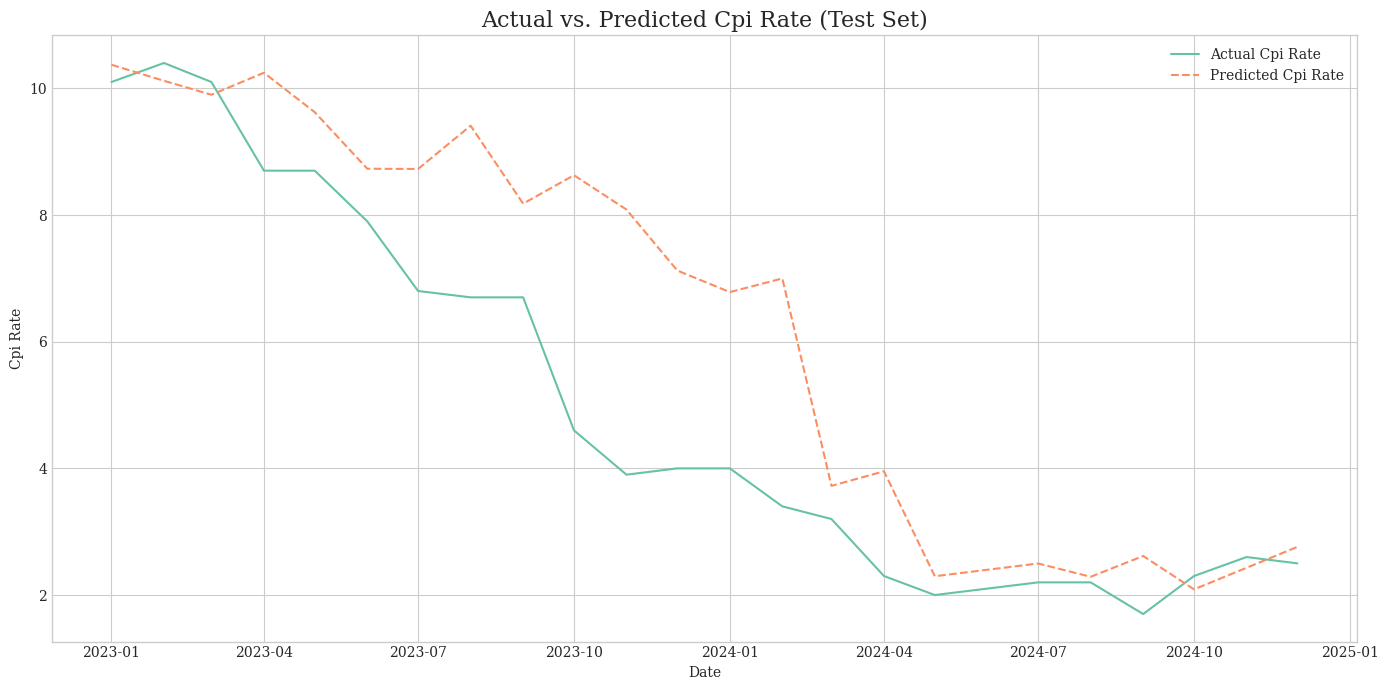

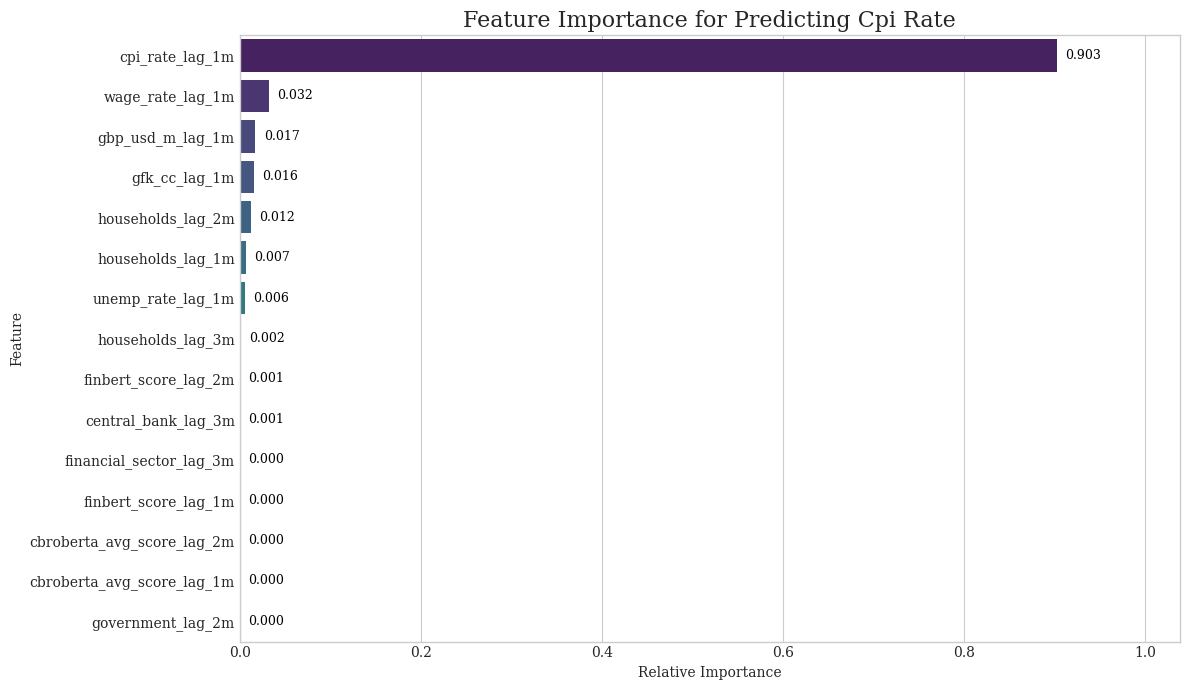


--- Modeling for Target: Gbp Usd M ---
Training data size: 88 samples
Testing data size: 23 samples
  Mean Squared Error (MSE): 0.0014
  R-squared (R2): -0.8114

  Top 10 Feature Importances:
                    Feature  Importance
22         gbp_usd_m_lag_1m    0.768732
21          cpi_rate_lag_1m    0.144825
25         wage_rate_lag_1m    0.024345
24        unemp_rate_lag_1m    0.011171
15        government_lag_1m    0.006631
23            gfk_cc_lag_1m    0.006023
13             firms_lag_2m    0.003848
6       central_bank_lag_1m    0.003509
1      finbert_score_lag_2m    0.003393
9   financial_sector_lag_1m    0.003108


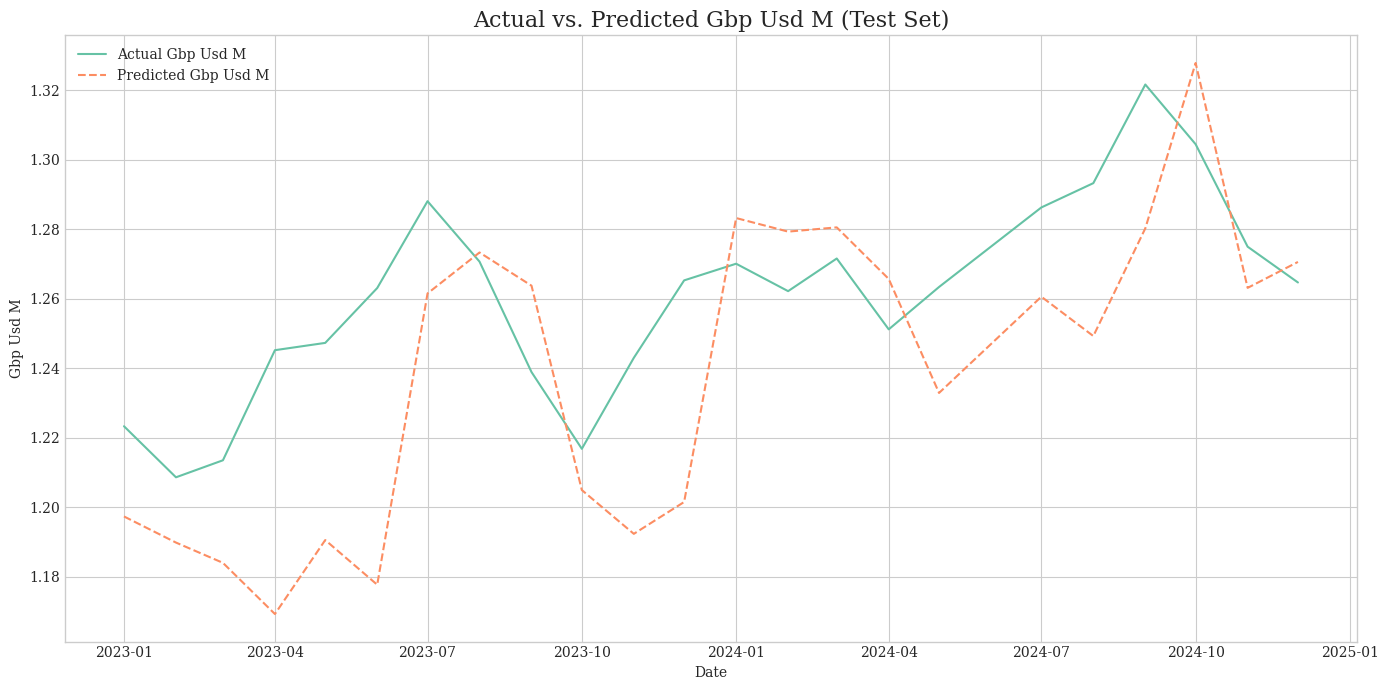

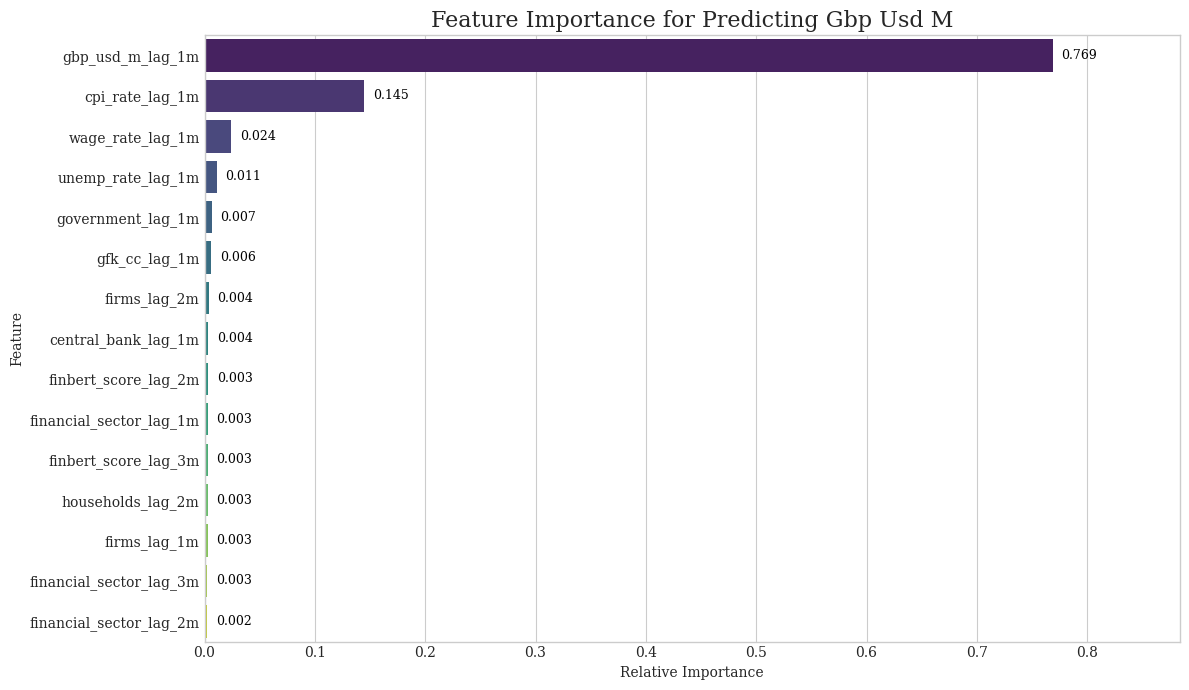


--- Modeling for Target: Gfk Cc ---
Training data size: 88 samples
Testing data size: 23 samples
  Mean Squared Error (MSE): 54.1280
  R-squared (R2): 0.0985

  Top 10 Feature Importances:
                       Feature  Importance
23               gfk_cc_lag_1m    0.731410
22            gbp_usd_m_lag_1m    0.086906
21             cpi_rate_lag_1m    0.064020
3   cbroberta_avg_score_lag_1m    0.030237
24           unemp_rate_lag_1m    0.027683
25            wage_rate_lag_1m    0.017469
10     financial_sector_lag_2m    0.009918
18           households_lag_1m    0.005019
15           government_lag_1m    0.003536
11     financial_sector_lag_3m    0.003486


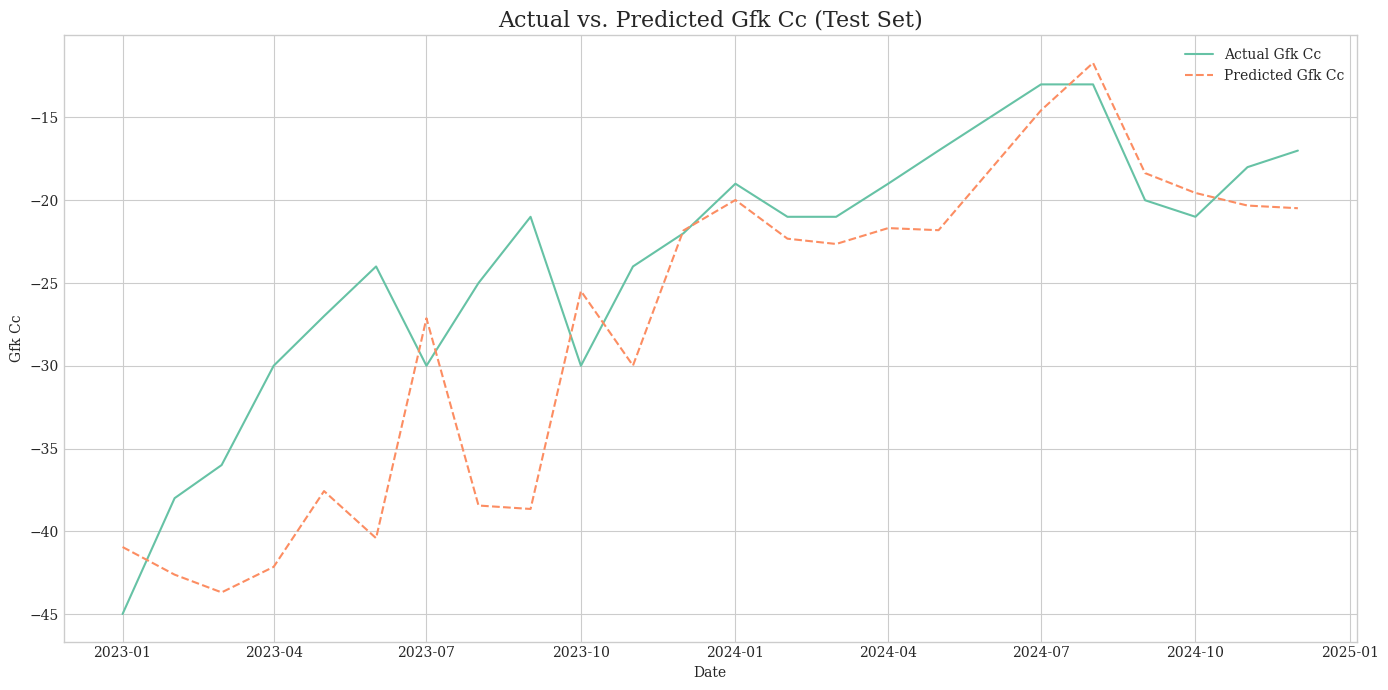

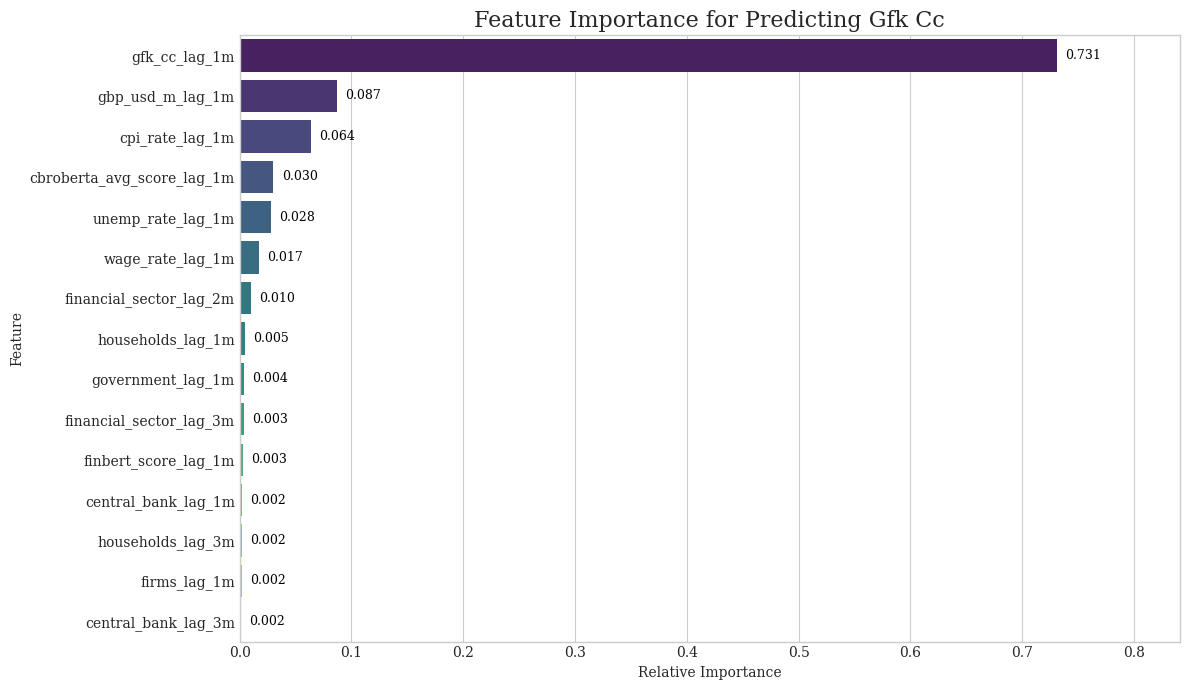


--- Modeling for Target: Unemp Rate ---
Training data size: 88 samples
Testing data size: 23 samples
  Mean Squared Error (MSE): 0.0289
  R-squared (R2): -0.0163

  Top 10 Feature Importances:
                    Feature  Importance
24        unemp_rate_lag_1m    0.912319
21          cpi_rate_lag_1m    0.038453
25         wage_rate_lag_1m    0.019197
0      finbert_score_lag_1m    0.004142
13             firms_lag_2m    0.003556
14             firms_lag_3m    0.003205
23            gfk_cc_lag_1m    0.002706
11  financial_sector_lag_3m    0.001903
1      finbert_score_lag_2m    0.001602
8       central_bank_lag_3m    0.001546


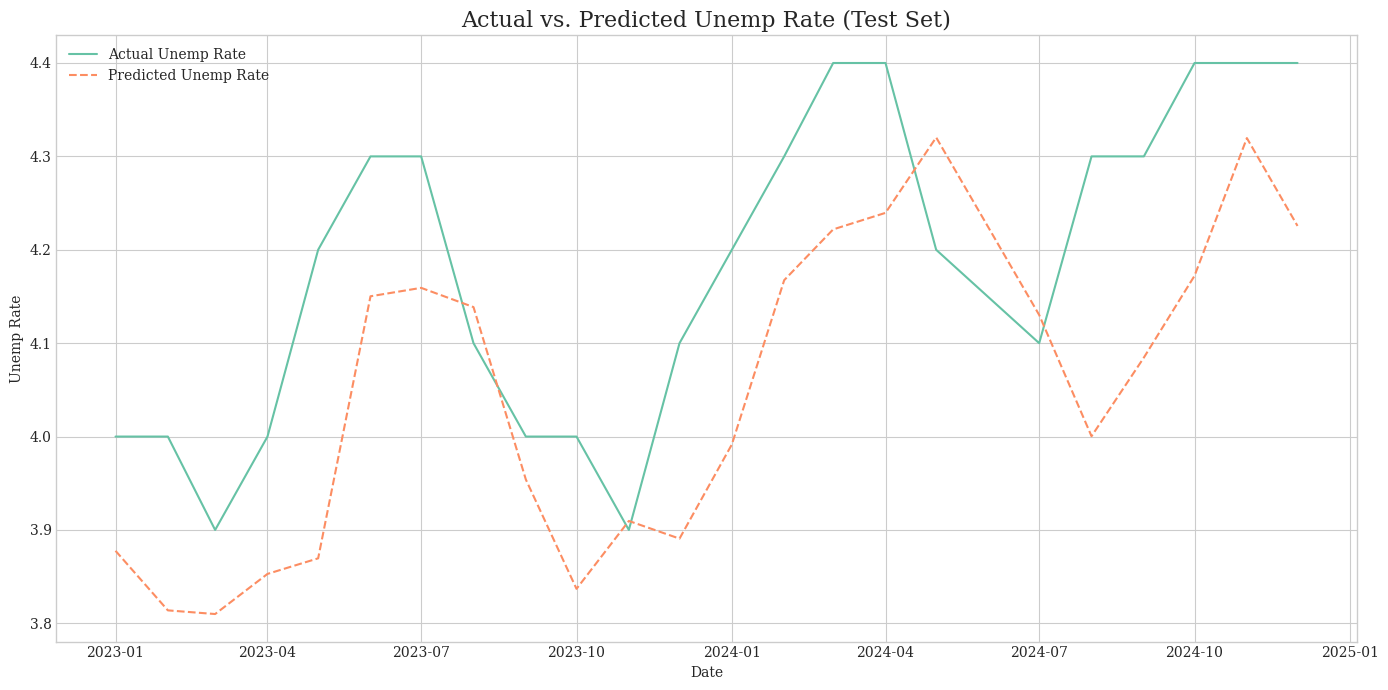

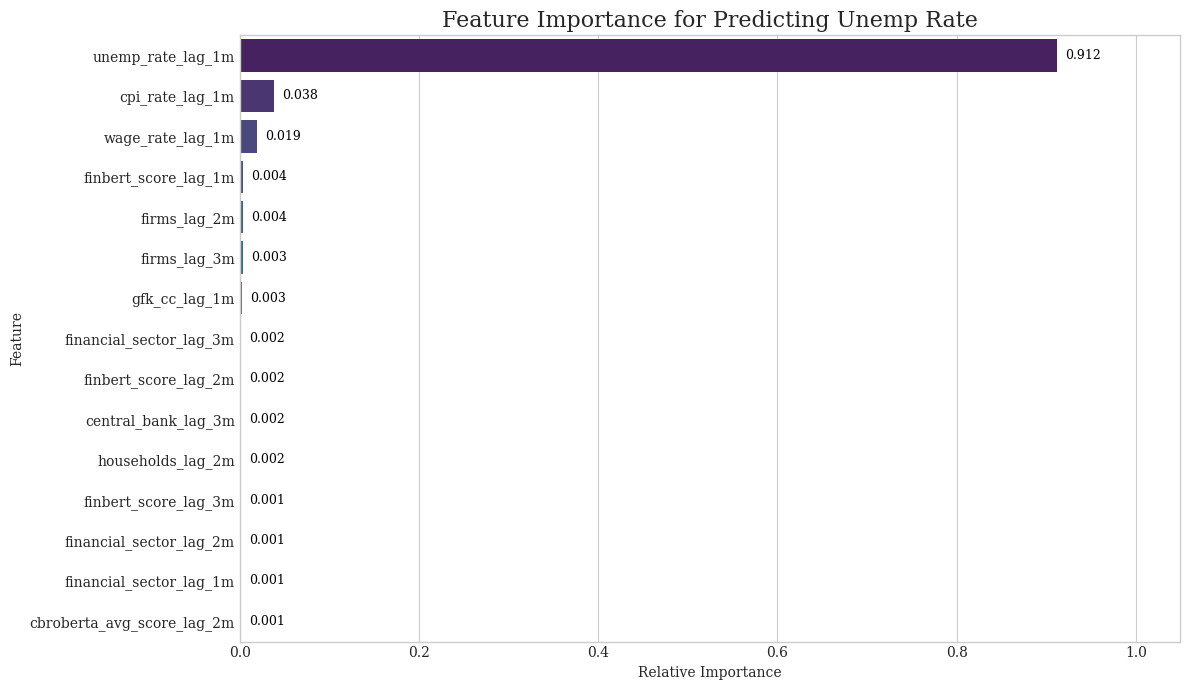


--- Modeling for Target: Wage Rate ---
Training data size: 88 samples
Testing data size: 23 samples
  Mean Squared Error (MSE): 0.7579
  R-squared (R2): 0.0686

  Top 10 Feature Importances:
                 Feature  Importance
25      wage_rate_lag_1m    0.916217
23         gfk_cc_lag_1m    0.030906
22      gbp_usd_m_lag_1m    0.010885
19     households_lag_2m    0.008446
18     households_lag_1m    0.005312
1   finbert_score_lag_2m    0.004642
8    central_bank_lag_3m    0.003417
16     government_lag_2m    0.002804
2   finbert_score_lag_3m    0.002005
0   finbert_score_lag_1m    0.001959


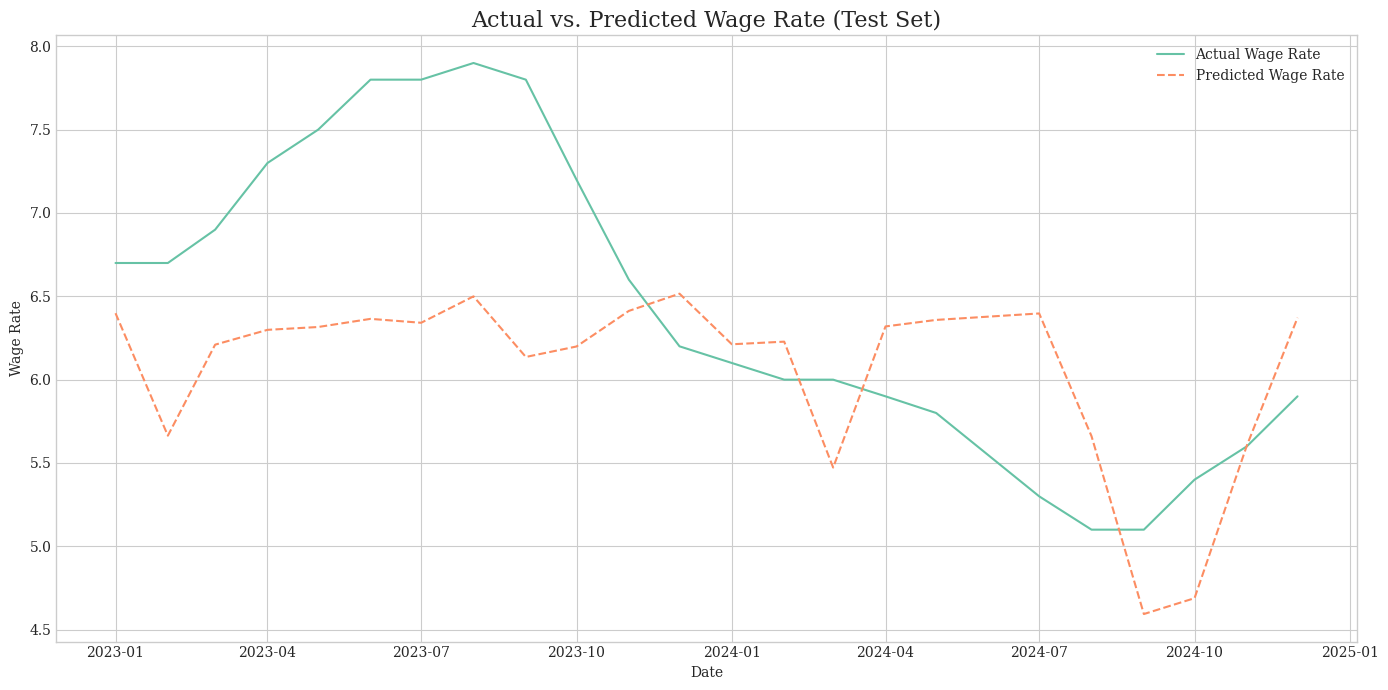

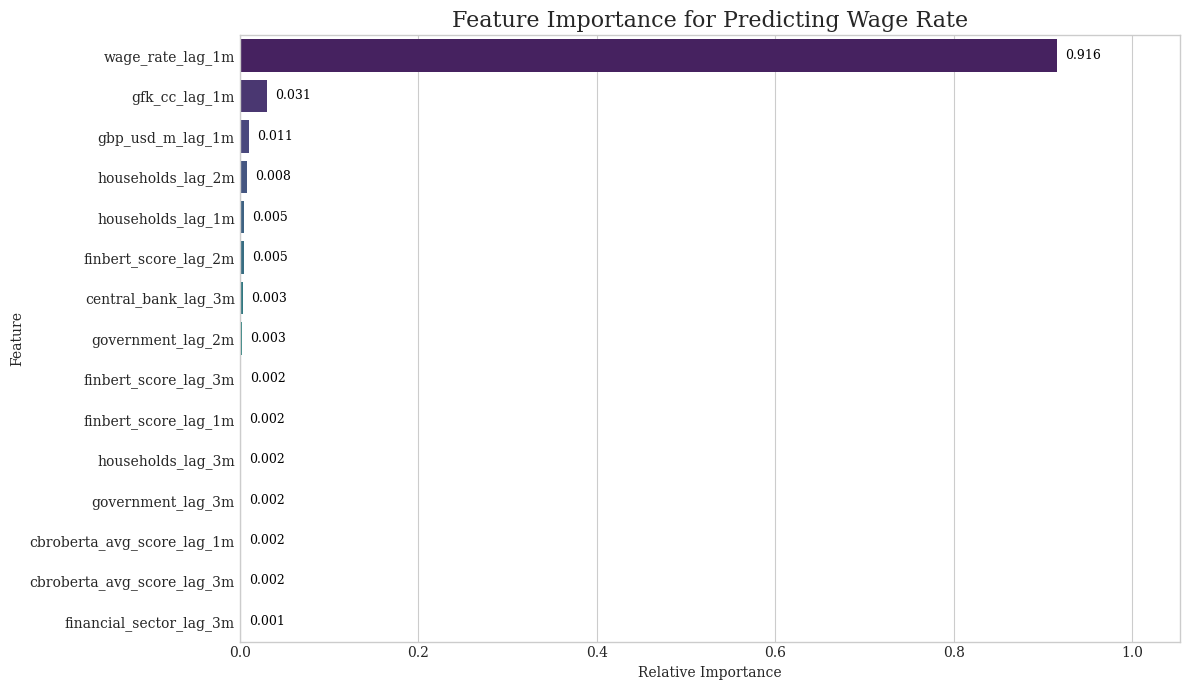


--- Modeling Complete ---


In [452]:
# Train and Evaluate Model for Each Economic Indicator
for target_econ_indicator in economic_targets:
    formatted_target = target_econ_indicator.replace('_', ' ').title()
    print(f"\n--- Modeling for Target: {formatted_target} ---")

    # Define the features (X) and the specific target (y)
    # Features will include all lagged sentiment and the lagged version of the current economic indicator
    current_features = [col for col in X_scaled.columns if col != f'{target_econ_indicator}_lag_1m']
    current_features.append(f'{target_econ_indicator}_lag_1m')

    X = X_scaled[all_lagged_features] # Use all lagged features that were scaled
    y = df_model_ready[target_econ_indicator]

    # Align X and y indices after dropping NaNs and before splitting
    common_index = X.index.intersection(y.index)
    X_aligned = X.loc[common_index]
    y_aligned = y.loc[common_index]

    # Split data into training and testing sets (80/20, shuffle=False for time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X_aligned, y_aligned, test_size=0.2, random_state=42, shuffle=False
    )

    print(f"Training data size: {len(X_train)} samples")
    print(f"Testing data size: {len(X_test)} samples")

    # Initialize and Train Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(random_state=42)
    gbr.fit(X_train, y_train)

    # Store the trained model
    models[target_econ_indicator] = gbr
    joblib.dump(gbr, f'gbr_model_{target_econ_indicator}.pkl') # Save model

    # Make predictions
    y_pred = gbr.predict(X_test)

    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'  Mean Squared Error (MSE): {mse:.4f}')
    print(f'  R-squared (R2): {r2:.4f}')

    # Feature Importance Analysis
    feature_importance = gbr.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("\n  Top 10 Feature Importances:")
    print(importance_df.head(10))

    # Store results
    results[target_econ_indicator] = {
        'mse': mse,
        'r2': r2,
        'feature_importance': importance_df
    }

    # Visualize Actual vs. Predicted (for each target)
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label=f'Actual {formatted_target}')
    plt.plot(y_test.index, y_pred, label=f'Predicted {formatted_target}', linestyle='--')
    plt.title(f'Actual vs. Predicted {formatted_target} (Test Set)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel(formatted_target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'actual_vs_predicted_{target_econ_indicator}.png')
    plt.show()

    # Visualize Top Feature Importances for each target
    plt.figure(figsize=(12, 7))
    # Using importance_df.head(15) directly for plotting to ensure consistent order
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')

    # Add numeric labels to the bars
    # Iterate through the data
    for i, (feature, importance) in enumerate(zip(importance_df['Feature'].head(15), importance_df['Importance'].head(15))):
        plt.text(importance + (importance_df['Importance'].max() * 0.01),
                 i,
                 f'{importance:.3f}',
                 color='black', ha='left', va='center', fontsize=9)

    plt.title(f'Feature Importance for Predicting {formatted_target}', fontsize=16)
    plt.xlabel('Relative Importance')
    plt.ylabel('Feature')
    # Adjust x-axis limit to accommodate labels
    plt.xlim(0, importance_df['Importance'].head(15).max() * 1.15)
    plt.tight_layout()
    plt.savefig(f'feature_importance_{target_econ_indicator}.png')
    plt.show()

print("\n--- Modeling Complete ---")

General insights

- Lagged Sentiment as a Predictor: Consistently, specific lagged sentiment features emerged as statistically significant predictors for future economic indicators, even after accounting for the indicator's own past values. This is a powerful finding, suggesting the Bank's communication is not merely reactive but possesses a proactive influence.
- For Inflation (CPI Rate), sentiment towards Households (2-month and 1-month lags) showed notable importance, indicating that the Bank's tone on household well-being can precede inflation shifts.
- For Consumer Confidence (GFK CC), Overall CBRoberta sentiment (1-month lag) and Financial Sector sentiment (2-month lag) were key, suggesting market participants take time to process financial stability signals, impacting broader consumer sentiment.
- For Wage Rate, again, Household sentiment (2-month and 1-month lags) played a significant role, highlighting the Bank's influence on labor market expectations.
- Dominance of Past Economic Data: As anticipated, the previous month's value of an economic indicator was almost always its strongest predictor. This underscores the inherent persistence and auto-correlation in economic time series. However, sentiment's contribution, though smaller in magnitude, represents a crucial additional layer of predictive insight.
Topic-Specific Impact: The analysis showed that different facets of sentiment (e.g., 'financial sector' vs. 'households') have varying degrees and lags of impact on different economic indicators. This points to the nuanced way specific communication themes resonate across the economy.

CPI Rate insights only

- For CPI Rates key sentiment predictors were how the Bank spoke about households, with a 2-month delay (Importance: 0.012), a 1-month delay (Importance: 0.007), and a 3-month delay (Importance: 0.002). These insights show that the Bank's tone on households significantly contributes to predicting future inflation.
- The model shows that past speech sentiment can indeed help explain and predict the direction of future economic indicators.  Our model predicts Inflation rates well, explaining 57% of its variation. Because financial markets strongly consider inflation, this forecasting ability gives market analysts valuable clues into its direction. A mean squared error of 3.73, while low, shows further model refinement is needed to make more accurate predictions. Options for model refinement could include experimenting with different values for sentiment lags and hyperparameter tuning.


Recommendations for Further Exploration:

- Establish a dedicated, real-time sentiment monitoring dashboard within the Bank. This system should track not only overall sentiment but also granular sentiment towards key economic agents (e.g., 'financial sector', 'households') with a specific focus on incorporating the lagged sentiment indicators (e.g., sentiment 1-3 months prior) that our model found as having significant predictive power.
- Direct Market Behavior Prediction: Investigate the correlation of intra-day speech sentiment with immediate, high-frequency market movements (e.g., FTSE 100, Gilt yields) using event-study methodologies.
- Advanced Time Series Modeling: Explore more sophisticated time series models (e.g., ARIMA with exogenous variables, VAR models) to capture more complex temporal dependencies.
- Expanded Sentiment Features: Incorporate additional linguistic features from speeches (e.g., readability, certainty markers, specific keyword frequencies) to enrich the sentiment signals.

# END